<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTSRB4] - Data augmentation 
<!-- DESC --> Episode 4 : Adding data by data augmentation when we lack it, to improve our results
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - Trying to improve training by **enhancing the data**
  - Using Keras' **data augmentation utilities**, finding their limits...
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  

Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


## What we're going to do :
 - Increase and improve the training dataset
 - Identify the limits of these tools

## Step 1 - Import and init
### 1.1 - Python stuffs

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import os, sys, time, random

from importlib import reload


run_dir = './run/GTSRB4.001'
datasets_dir='fidle-datasets'

### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)\
`fit_verbosity` is the verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch

In [2]:
enhanced_dir = './data'
# enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'

dataset_name  = 'set-24x24-L'
batch_size    = 64
epochs        = 40
scale         = 1
fit_verbosity = 1


## Step 2 - Load dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use a smart dataset : **set-24x24-L**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [3]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    
    # ---- Shuffle
    #x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset 
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#

def rescale_dataset(*data, scale=1):
    '''
    Rescale numpy array with 'scale' factor
    args:
        *data : arrays
        scale : scale factor
    return:
        arrays of rescaled data
    '''
    return [ d[:int(scale*len(d))] for d in data ]

# x_train,y_train, x_test,y_test = rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(1960, 24, 24, 1) (1960,)


## Step 3 - Models
We will now build a model and train it...

In [4]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

## Step 4 - Callbacks  
We prepare 2 kind callbacks :  TensorBoard and Model backup

In [5]:
def mkdir(path):
    os.makedirs(path, mode=0o750, exist_ok=True)
def tag_now():
    return datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%Ss")

In [6]:
import datetime

mkdir(run_dir + '/models')
mkdir(run_dir + '/logs')

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

path=os.path.abspath(f'{run_dir}/logs')
print(f'To run tensorboard :\ntensorboard --logdir {path}')

To run tensorboard :
tensorboard --logdir C:\Users\Massimo\projet__DS\Formation\run\GTSRB4.001\logs


## Step 5 - Data generator

In [7]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)
datagen.fit(x_train)

## Step 6 - Train the model
**Get my data shape :**

In [8]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [9]:
model = get_model_v1(lx,ly,lz)

# model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train it :** 

In [10]:
history = model.fit(  datagen.flow(x_train, y_train, batch_size=batch_size),
                      steps_per_epoch = int(x_train.shape[0]/batch_size),
                      epochs=epochs,
                      verbose=fit_verbosity,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.h5')

Epoch 1/40
30/30 [==============================] - 6s 185ms/step - loss: 3.5702 - accuracy: 0.0622 - val_loss: 3.5118 - val_accuracy: 0.0761
Epoch 2/40
30/30 [==============================] - 6s 189ms/step - loss: 3.4401 - accuracy: 0.0765 - val_loss: 3.4417 - val_accuracy: 0.0713
Epoch 3/40
30/30 [==============================] - 6s 207ms/step - loss: 3.3489 - accuracy: 0.0949 - val_loss: 3.3207 - val_accuracy: 0.1379
Epoch 4/40
30/30 [==============================] - 5s 169ms/step - loss: 3.1887 - accuracy: 0.1540 - val_loss: 3.0772 - val_accuracy: 0.2029
Epoch 5/40
30/30 [==============================] - 6s 188ms/step - loss: 2.9378 - accuracy: 0.2305 - val_loss: 2.6737 - val_accuracy: 0.2964
Epoch 6/40
30/30 [==============================] - 6s 186ms/step - loss: 2.6500 - accuracy: 0.2880 - val_loss: 2.3068 - val_accuracy: 0.3772
Epoch 7/40
30/30 [==============================] - 6s 203ms/step - loss: 2.3231 - accuracy: 0.3565 - val_loss: 2.0620 - val_accuracy: 0.4263
Epoch 

**Evaluate it :**

In [11]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.8288


In [12]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.6479
Test accuracy  : 0.8209


## Step 7 - History
The return of model.fit() returns us the learning history

In [13]:
import pandas as pd
df=pd.DataFrame(data=history.history)

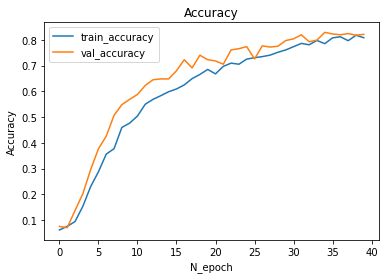

In [14]:
plt.figure()
plt.plot(df['accuracy'],label='train_accuracy')
plt.plot(df['val_accuracy'],label='val_accuracy')
plt.title("Accuracy")
plt.xlabel('N_epoch')
plt.ylabel('Accuracy')
plt.legend()

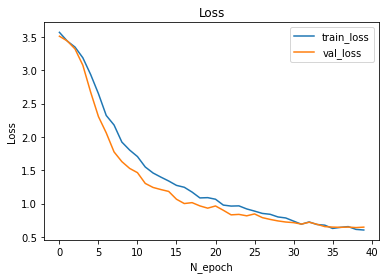

In [15]:
plt.figure()
plt.plot(df['loss'],label='train_loss')
plt.plot(df['val_loss'],label='val_loss')
plt.title("Loss")
plt.xlabel('N_epoch')
plt.ylabel('Loss')
plt.legend()

## Step 8 - Evaluate best model

### 8.1 - Restore best model :

In [17]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
# best_model.summary()
print("Loaded.")

Loaded.


### 8.2 - Evaluate it :

In [18]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.6414
Test accuracy  : 0.8177


**Plot confusion matrix**

In [19]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

<AxesSubplot:>

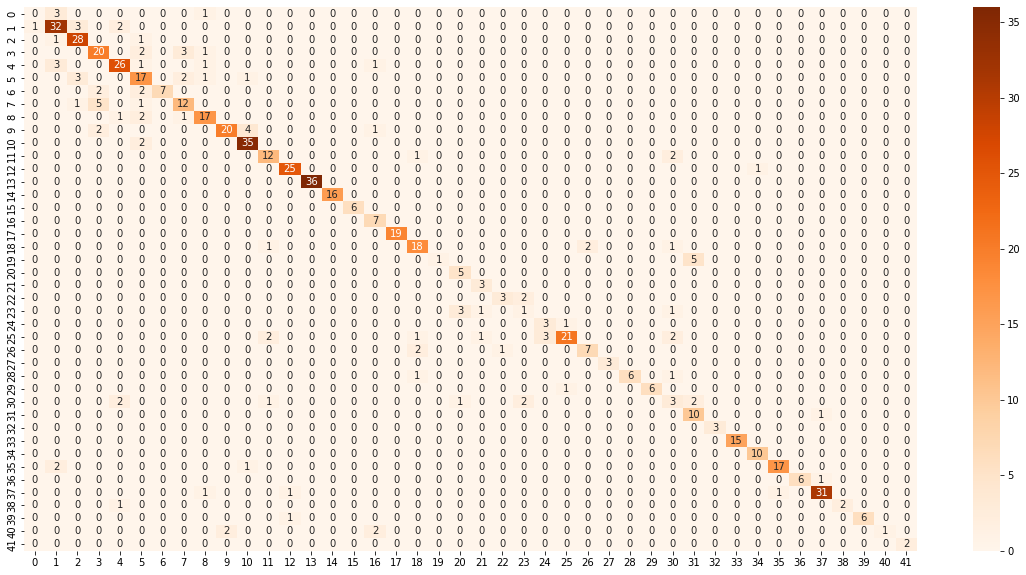

In [20]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt='1', cmap='Oranges')